In [1]:
%matplotlib inline

In [2]:
from kmr import KMR

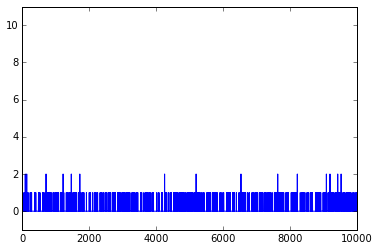

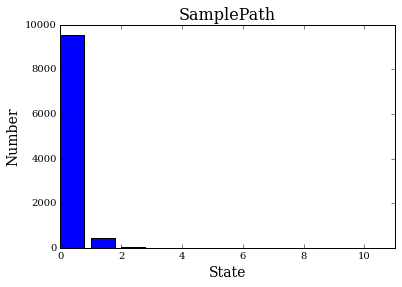

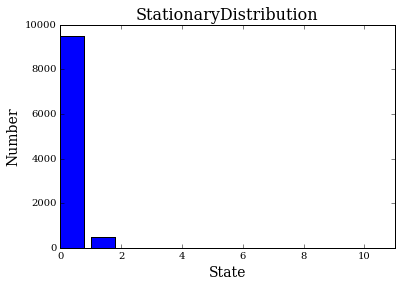

In [3]:
seq = KMR(0.333, 10, 0.01, mode="sim")
seq.sample_path(init=2,sample_size=10000, plot=1)
seq.plot("samp")
seq.plot("stat")

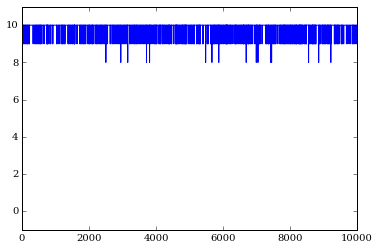

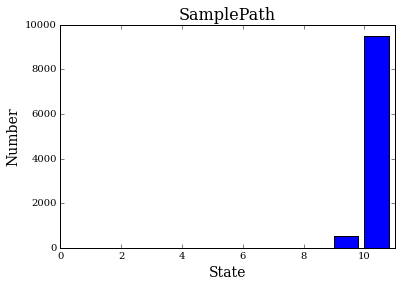

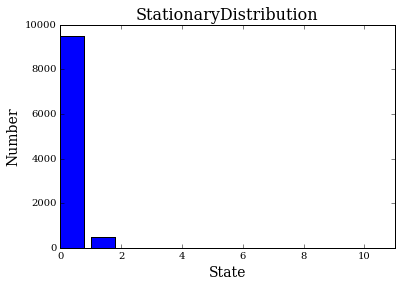

In [4]:
seq = KMR(0.333, 10, 0.01, mode="sim")
seq.sample_path(init=7,sample_size=10000, plot=1)
seq.plot("samp", init=7)
seq.plot("stat")

In [5]:
seq.compute_stationary_distribution()

[0.95112, 0.04779, 0.00108, 1e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

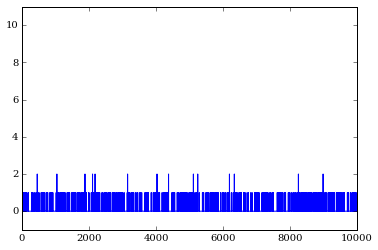

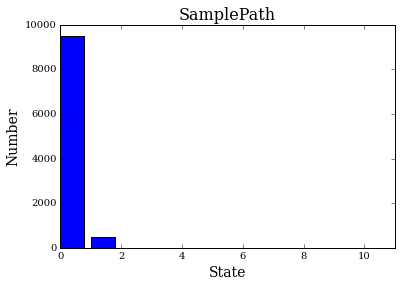

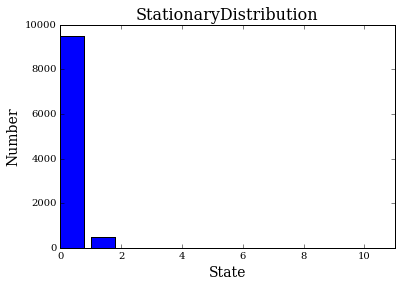

In [6]:
sim = KMR(0.333, 10, 0.01, mode="sim")
sim.sample_path(init=0,sample_size=10000,plot=1)
sim.plot("samp")
sim.plot("stat")

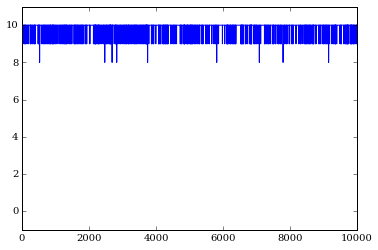

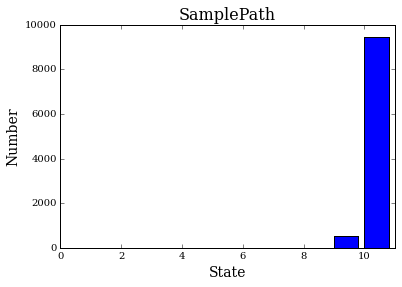

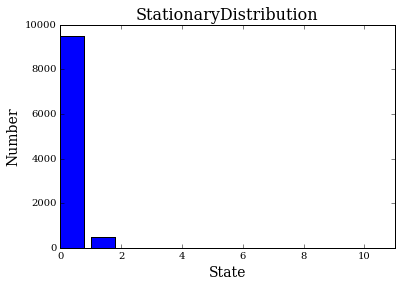

In [7]:
sim = KMR(0.333, 10, 0.01, mode="sim")
sim.sample_path(init=7,sample_size=10000,plot=1)
sim.plot("samp", init=7)
sim.plot("stat")

In [8]:
sim.compute_stationary_distribution()

[0.95112, 0.04779, 0.00108, 1e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]